In [1]:
# Import necessary libraries for data manipulation, visualization, and analysis
import socceraction
import socceraction.spadl as spadl
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
import warnings
from mplsoccer import Pitch, VerticalPitch, lines
from scipy.ndimage import gaussian_filter
from PIL import Image
import urllib

In [2]:
# Configure pandas display options and suppress specific warnings
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed in DataFrame outputs
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)  # Ignore performance warnings from pandas
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")  # Suppress credential-related warnings

In [3]:
# Load custom fonts for visualization
fe_regular = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-Regular.ttf',
    name='SourceSansPro-Regular'
)
fe_semibold = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-SemiBold.ttf',
    name='SourceSansPro-SemiBold'
)

# Insert both fonts into the font manager
fm.fontManager.ttflist.insert(0, fe_regular)
fm.fontManager.ttflist.insert(1, fe_semibold)

# Set the font family to the custom regular font
matplotlib.rcParams['font.family'] = fe_regular.name

In [4]:
# Load datasets from CSV files
xG = pd.read_csv("xGactions.csv", index_col=0)  # Expected goals data
fb = pd.read_csv("teamsFOTMOB.csv", index_col=0)  # Ids mapping from FOTMOB and Whoscored
players = pd.read_csv("players2425.csv", index_col=0)  # Players data
games = pd.read_csv("games2425.csv", index_col=0)  # Games data
actions = pd.read_csv("actions2425.csv", index_col=0)  # Events data

In [5]:
# Select relevant columns from games dataset
games = games[["game_id", "competition_id", "season_id"]]

# Select relevant player information
players_info = players[['game_id', 'team_id', 'player_id', 'player_name', 'season_id', 'competition_id']]

# Add descriptive action names to the actions DataFrame
actions = spadl.add_names(actions)

In [6]:
# Merge datasets to create a unified DataFrame
df = (
    actions
    .merge(fb, how="left")  # Merge mapping data
    .merge(xG, how="left")  # Merge expected goals data
    .merge(games, how="left")  # Merge games data
    .merge(players_info, how="left")  # Merge player information
)

In [7]:
# Calculate movement distances and angles
df["beginning_distance"] = np.sqrt(np.square(105 - df['start_x_a0']) + np.square(34 - df['start_y_a0'])).round(2)
df["end_distance"] = np.sqrt(np.square(105 - df['end_x_a0']) + np.square(34 - df['end_y_a0'])).round(2)
df["length"] = df["end_distance"] - df["beginning_distance"]
df['length'] = df['length'].abs()  # Ensure length values are always positive

df["angle"] = np.arctan2(df["end_y_a0"] - df["start_y_a0"], df["end_x_a0"] - df["start_x_a0"])  # Calculate angle in radians
df['angle_degrees'] = np.degrees(df['angle']) % 360  # Convert angle to degrees and normalize it to 0-360 range

In [8]:
# Function to format season ID into a readable format
def format_season_id(season_id):
    # Convert to integer if it's a float
    season_id = int(season_id)
    # Extract the last two digits of the year
    start_year = str(season_id - 1)[-2:]
    # Calculate the end year
    end_year = str(season_id)[-2:]
    # Format as 20/21
    formatted_season = f"{start_year}/{end_year}"
    return formatted_season

In [9]:
# Filter data for non penalty shot-related events
df1 = df[df["type_name"].isin(["shot", "shot_freekick"])]

In [10]:
# Select a specific player
player = 'Randal Kolo Muani'

In [11]:
# Filter actions and player data for the selected player
df2 = df1[df1["player_name"] == player]
pla = players[players["player_name"] == player]

# Print unique team names and ids for the player
print(df2.team_name.unique())
print(pla.team_id.unique())

['PSG' 'Juventus']
[304  87]


In [12]:
# Define team information
team = 'Juventus'
teamid = 87

In [13]:
# Filter player actions and data for the specified team
df2a = df2[df2["team_name"] == team]
plb = pla[pla["team_id"] == teamid]
df2a.season_id.unique()

array([2425])

In [14]:
# Apply the function to the 'season_id' column
df2a['formatted_season'] = df2a['season_id'].apply(format_season_id)

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_8604/2406992386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2a['formatted_season'] = df2a['season_id'].apply(format_season_id)


In [15]:
# Further filter data for the season
df3 = df2a[df2a["season_id"].isin([2425.])]
pl = plb[plb["season_id"].isin([2425.])]

In [16]:
#Create a definition to convert minutes in seconds played for formatting and final visualization reasons
def convert_to_seconds(time_str):
    try:
        # Convert to string in case it's a float (e.g., NaN)
        time_str = str(time_str)
        # Split the time string into minutes and seconds
        minutes, seconds = map(int, time_str.split(':'))
        # Convert total time to seconds (minutes converted to seconds)
        return minutes * 60 + seconds
    except (ValueError, AttributeError):
        # Handle cases where the conversion fails (e.g., NaN or bad format)
        return 0  # or use `np.nan` if you prefer to mark as missing

# Apply the conversion function to the 'minutes_played' column
pl['seconds_played'] = pl['minutes_played'].apply(convert_to_seconds)

In [17]:
#Creating the minutes formatted to insert in the viz
minutes = pl.groupby(["player_id", "player_name"])['seconds_played'].sum().reset_index(name='seconds_played')

In [18]:
# Function to convert total seconds to MM:SS format
def convert_to_mmss(seconds):
    if pd.isna(seconds) or seconds is None:
        return np.nan  # Return NaN if the input is None or NaN
    seconds = int(seconds)  # Ensure the input is an integer
    minutes = seconds // 60  # Calculate the minutes
    seconds = seconds % 60   # Calculate the remaining seconds
    return f"{minutes:02}:{seconds:02}"  # Format as MM:SS with leading zeros

# Apply the function to the 'duration_seconds' column to create a new column for the calculated minutes
minutes['calculated_min'] = minutes['seconds_played'].apply(convert_to_mmss)

In [19]:
#Divide between goals and non goals shots
df1shot = df3[df3["result_name"] == "fail"]
df1goal = df3[df3["result_name"] != "fail"]

In [20]:
#Definition to automatically retrieve player name and insert in the tilte function
nrows = df3.shape[0]
for y in range(nrows):
    title = df3['player_name'].iloc[y]

# Define the semicircle function
def semicircle(r, h, k):
    x0 = h - r  # x start
    x1 = h + r  # x finish
    x = np.linspace(x0, x1, 10000)  # many points to solve for y
    y = k - np.sqrt(r**2 - (x - h)**2)  # semicircle equation
    return x, y

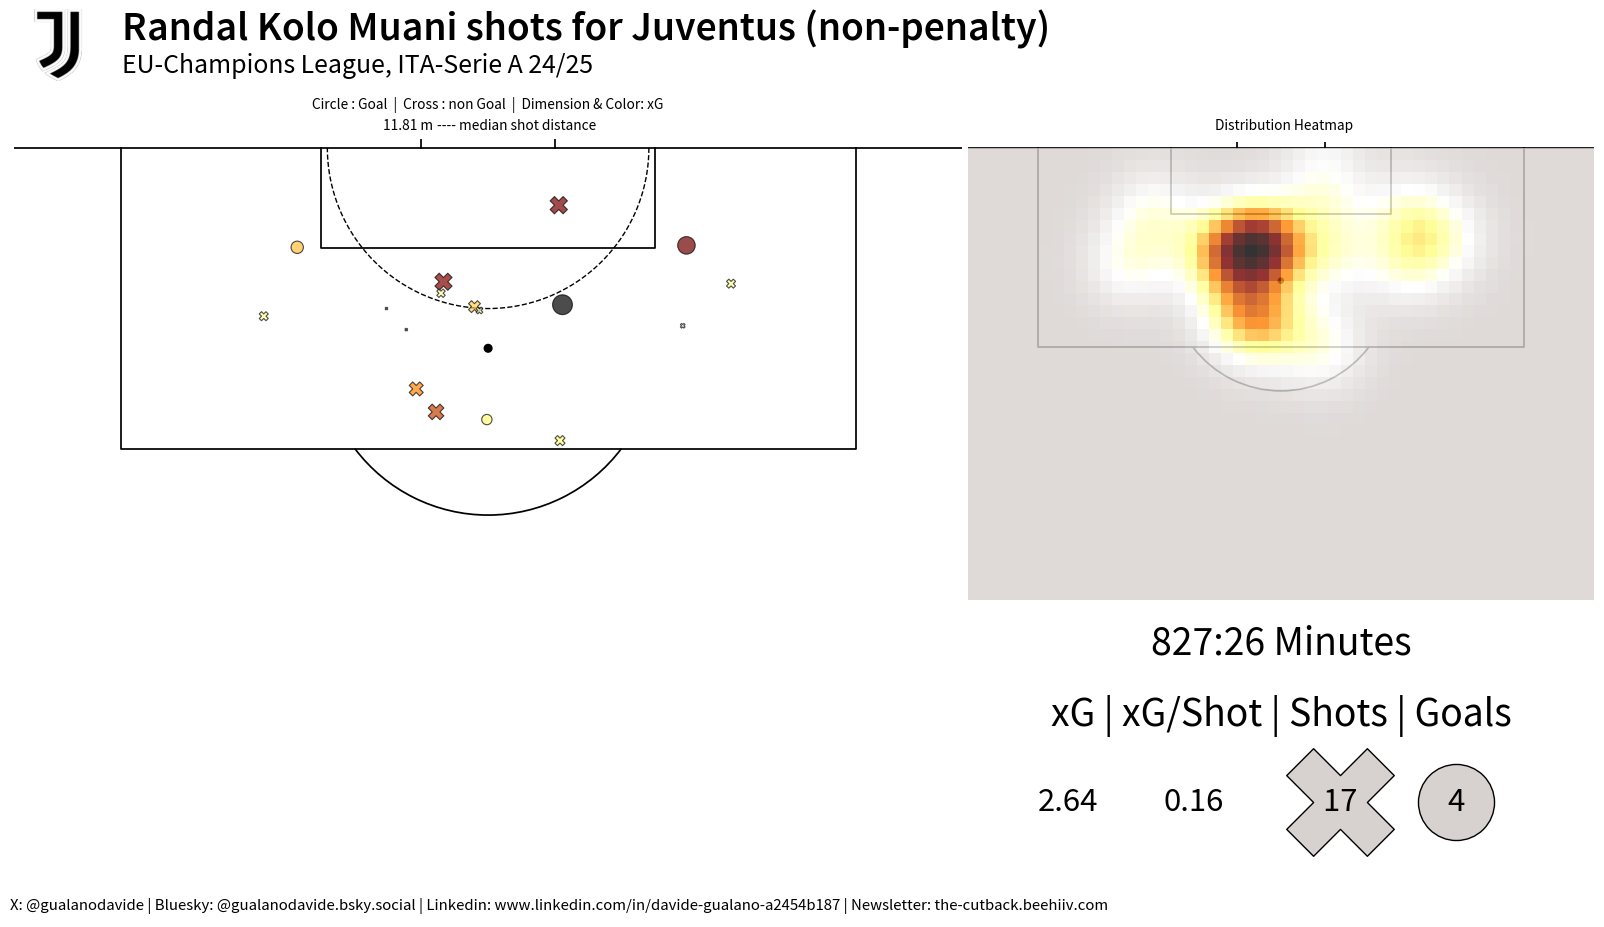

In [21]:
# Set up gridspec figure
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
gs = fig.add_gridspec(3, 5, wspace=0.1, hspace=0.1)

# Create the axes
ax1 = fig.add_subplot(gs[:, :3]) 

ax2 = fig.add_subplot(gs[0:3, 3:]) 
pos2 = ax2.get_position() 
new_pos2 = [pos2.x0, pos2.y0 + 0.1, pos2.width + 0.09, pos2.height]  # Increase the 'bottom' value by 0.2
ax2.set_position(new_pos2)  # Apply the new position

ax3 = fig.add_subplot(gs[2:, 3:])
pos3 = ax3.get_position() 
new_pos3 = [pos3.x0, pos3.y0 + 0.03, pos3.width + 0.09, pos3.height]  # Increase the 'bottom' value by 0.2
ax3.set_position(new_pos3)

#Create the pitches
pitch = VerticalPitch(pitch_type='custom', pitch_width=68, pitch_length=105, half=True, pad_top=0.5, pad_bottom=-15, pad_left=-8,
                      pad_right=-8, goal_type='box', linewidth=1.25, line_color='#000000')

pitch.draw(ax=ax1)
pitch.draw(ax=ax2)

# Draw semicircle on both pitches
x_circle, y_circle = semicircle(105 - df3['start_x_a0'].median(), 34, 105)
ax1.plot(x_circle, y_circle, ls='--', color='#000000', lw=1, zorder=-1)

# Scatter plot for shots on both pitches
cmap0 = matplotlib.colormaps.get_cmap('afmhot_r')
combined_xG = pd.concat([df1shot.xG, df1goal.xG])
norm = plt.Normalize(combined_xG.min(), combined_xG.max())
pitch.scatter(df1shot.start_x_a0, df1shot.start_y_a0, s=(df1shot.xG * 500), cmap=cmap0, edgecolors='#000000', c=df1shot.xG, norm=norm,
               marker='X', alpha=0.7, lw=0.8, ax=ax1, zorder=1)
pitch.scatter(df1goal.start_x_a0, df1goal.start_y_a0, s=(df1goal.xG * 500), cmap=cmap0, edgecolors='#000000', c=df1goal.xG, norm=norm,
               marker='o', alpha=0.7, lw=0.8, ax=ax1)

# Define the colormap with #D7D1CF as the lowest value
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#D7D1CF', '#FFFFFF', '#FFFF80', '#FF8000', '#800000', '#000000'], N=256)
bin_statistic = pitch.bin_statistic(df3.start_x_a0, df3.start_y_a0, statistic='count', bins=(105, 68))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 2.5)
pcm = pitch.heatmap(bin_statistic, ax=ax2, cmap=cmap, alpha=0.8)

# Titles for both subplots
title = df3['player_name'].iloc[0]
team_name = df3['team_name'].iloc[0]
competition_ids = ', '.join(df3['competition_id'].unique())
formatted_season = df3['formatted_season'].iloc[0]
season_id = df3['season_id'].iloc[0]
median_distance = df3['beginning_distance'].median()
converted_distance = round(median_distance, 2)

# Titles
ax1.text(0.5, 1.05, f"Circle : Goal  |  Cross : non Goal  |  Dimension & Color: xG", color=pitch.line_color,
        va='center', ha='center', fontsize=11, transform=ax1.transAxes)
ax1.text(0.53, 1.02, f"---- median shot distance", color=pitch.line_color,
        va='center', ha='center', fontsize=11, transform=ax1.transAxes)
ax1.text(0.416, 1.02, f"{converted_distance} m", color=pitch.line_color,
        va='center', ha='center', fontsize=11, transform=ax1.transAxes)

ax2.text(1.34, 1.02, f"Distribution Heatmap", color=pitch.line_color,
        va='center', ha='center', fontsize=11, transform=ax1.transAxes)

fig.text(0.07, 0.88, f'{title} shots for {team_name} (non-penalty)', fontsize=30, va='center', ha='left', fontfamily='SourceSansPro-SemiBold')
fig.text(0.07, 0.85, f'{competition_ids} {formatted_season}', fontsize=20, va='center', ha='left')
fig.text(0, 0.15, 'X: @gualanodavide | Bluesky: @gualanodavide.bsky.social | Linkedin: www.linkedin.com/in/davide-gualano-a2454b187 | Newsletter: the-cutback.beehiiv.com', va='center', ha='left', fontsize=12)

# Add content to ax3 (example: you can add more annotations or plots here)
ax3.text(0.5, 0.7, f"xG | xG/Shot | Shots | Goals", fontsize=30, va='center', ha='center')
ax3.text(0.16, 0.4, f"{(df3['xG'].sum()).round(2)}", fontsize=25, va='center', ha='center')
ax3.text(0.36, 0.4, f"{(df3['xG'].sum() / df3.shape[0]).round(2)}", fontsize=25, va='center', ha='center')
ax3.text(0.6, 0.4, f"{df3.shape[0]} ", fontsize=25, va='center', ha='center')
ax3.text(0.78, 0.4, f"{df3[df3['result_name'] == 'success'].shape[0]}", fontsize=25, va='center', ha='center')
ax3.scatter(0.595, 0.4, s=6000, edgecolors='#000000', c='#D7D1CF', marker='X', alpha=1, lw=1)
ax3.scatter(0.78, 0.4, s=3000, edgecolors='#000000', c='#D7D1CF', marker='o', alpha=1, lw=1)

ax3.text(0.5, 0.95, f"{', '.join(minutes['calculated_min'].unique())} Minutes", fontsize=30, va='center', ha='center')

ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')

#Adding the club logo
DC_to_FC = ax3.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

ax_size = 0.06
y = 4.36
# Get the data coordinates for the specific x and y values
data_coords = DC_to_FC((-4, (y * 1.18) - 2.25))  # This returns a tuple
ax_coords = FC_to_NFC(data_coords)  # Transform to figure coordinates

# Adjust the x-coordinate
adjusted_x = 0
ax_coords = (adjusted_x, ax_coords[1])  # Create new ax_coords with adjusted x

# Retrieve the team_id and team_name from the DataFrame
team_id = fb[fb['team_name'] == team]['fotmob_id'].iloc[0]
team_name = team  # Team name is already defined

# Add an axis for the image
image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'

try:
    player_face = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id}.png")).convert('RGBA')
    image_ax.imshow(player_face)
except Exception as e:
    print(f"Error loading image for team {team_name}: {e}")
    # If an error occurs, you might want to exit or handle it differently.
    # 'continue' is removed because it's not in a loop.

image_ax.axis("off")

# Save the figure
plt.savefig(f'{title}-shotmap-{season_id}.png', dpi=500, facecolor="#D7D1CF", bbox_inches="tight", transparent=True)
plt.show()
